# INFO 204 Lecture 12 - Convolutional Neural Networks

Recall from the lecture that one of the key advantages of neural networks is their ability to readily exploit available structure in a problem (in other words, when there is clear feature interactions that are brought about by the arrangement of the features, such as pixels in an image). In this notebook, we will take a quick look at one type of structure-exploiting network, the [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network).

## Tensorflow and Keras
The examples in this notebook are implemented using the [tensorflow](https://www.tensorflow.org/) and [keras](https://keras.io/) libraries. ***This is not a tutorial on tensorflow or keras***. The best way to learn these tools is to follow the [tutorials provided by tensorflow](https://www.tensorflow.org/tutorials).

[Installing tensorflow](https://www.tensorflow.org/install) will also install a compatible version of keras. Tensorflow is best-suited for Windows and Linux environments ***with an NVIDIA GPU*** - you can install it on macOS, but it will not include GPU support and can potentially run quite slowly.

<span style="color: #ce2227;">Tensorflow can be somewhat challenging to install (it requires a suitable driver, runtime, and Python bindings), so in all cases if you are uncomfortable with the process, we recommend using [Google Colab](https://research.google.com/colaboratory/) for running this notebook.</span>

In [ ]:
import numpy as np

import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix

from matplotlib import pyplot as plt

batch_size = 192
no_epochs = 25
no_classes = 10
validation_split = 0.2
verbosity = 1

print("Available GPUs: {}".format(tf.config.list_physical_devices('GPU')))

# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

## The MNIST Problem

For this notebook, we will use the famous (and somewhat basic!) example problem of predicting the number corresponding to handwritten digits (the MNIST problem). We will use logistic regression and a well-known convolutional neural network to solve the problem.

Essentially, our data are 28x28 greyscale images, for example:

In [ ]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], X_train.shape[2], 1)
input_shape = X_train.shape[1:3] + (1, )

X_train, X_test = X_train / 255.0, X_test / 255.0

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(18,18))
for id in range(25):
    axs[id // 5][id % 5].matshow(X_train[id, :, :, 0], cmap='gray_r')

In this case, we have transformed the images to be 28x28 images with one channel (a floating-point number between zero and one to represent the shade of grey.

Later on in this notebook, we'll want to draw the "misclassified" images, so here's a helper routine for that:

In [ ]:
def plot_misclassified(images, y_true, y_pred, actual_class=9, predicted_class=5, required_cols=5, figure_width=15):
    from matplotlib import pyplot as plt
    from itertools import product
    
    act_as_pred = images[(y_true == actual_class) & (y_pred == predicted_class)]
    reqd_rows = np.ceil(len(act_as_pred) / required_cols).astype(int)
    fig, axs = plt.subplots(nrows=reqd_rows, ncols=required_cols, figsize=(figure_width, figure_width * reqd_rows / required_cols))
    for r, c, in product(range(reqd_rows), range(required_cols)):
        axs[r][c].set_axis_off()
    for idx, img in enumerate(act_as_pred):
        axs[idx // required_cols][idx % required_cols].matshow(img, cmap='gray_r')
        axs[idx // required_cols][idx % required_cols].set_axis_on()
    plt.tight_layout()

# Logistic Regression

We start with a logistic regression on the features - this will simply use the information of the individual pixels to predict the corresponding digit (in other words, the prediction model will only consider pixel value, not pixel location or proximity to other pixels). If we view this as a network, a logistic regression is simply a neural network with no hidden layer:

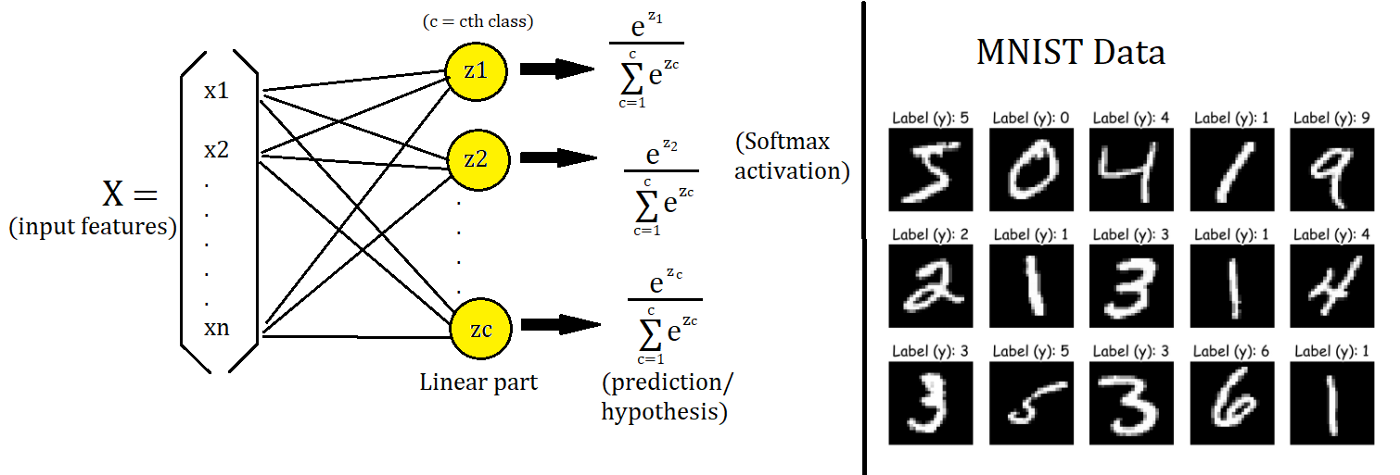<br />
[image source](https://towardsdatascience.com/softmax-regression-in-python-multi-class-classification-3cb560d90cb2)

Therefore, we can implement the logistic regression as a network in tensorflow as follows:

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ## this defines our loss function for the network

## define the network structure - the Flatten layer essentially takes our 28x28 image and "flattens" it into a 784x1 array
lm = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(), ## convert into 784x1
    tf.keras.layers.Dense(10)  ## feed directly into a fully-connected output layer
])

lm.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy']) ## configure the model with required hyperparameters

## fit the model
lm.fit(X_train, y_train,
       batch_size=batch_size,
       epochs=no_epochs,
       verbose=verbosity,
       validation_split=validation_split)

z = lm.predict(X_test) ## predict the logits, can convert these to p via: exp(z) / sum(exp(z))

## largest logit equates to largest probability, so pick element in z that is largest and that
## will be our class prediction
y_pred = np.argmax(z, axis=1)

print("Logistic Regression Details:")
print(lm.summary())
print("Logistic Regression Performance:")
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

The process is stochastic (contains a random element), so each run should give you a slightly different result - however, you should reasonably expect to see an accuracy of 92-93% and some interesting relationships in the confusion matrix that suggest some digits appear to have overlapping characteristics with other digits (hence confusion). For example, many "9" images were classified as representing the digit "4". We can take a look at these images as follows:

In [ ]:
plot_misclassified(X_test, y_test, y_pred, actual_class=9, predicted_class=4)

And the actual "2" instances that were classified as an "8":

In [ ]:
plot_misclassified(X_test, y_test, y_pred, actual_class=2, predicted_class=8)

I think it's fair to say that a lot of these examples are questionable twos!

## Convolutional Neural Network (LeNet 5)

The logistic regression was able to obtain an accuracy score of around 92-93%. The classes in this problem are well-balanced, so accuracy is a fair measurement of performance here. 92-93% seems pretty good (although, we really need a proper definition of "good" here), but it's likely that we can do better if we try to factor in the _structure_ of the problem.

In the late 1980s and into the 1990s, there was quite a lot of pioneering work done into convolutional neural networks (ConvNet). This work resulted in the ["LeNet-5"](https://en.wikipedia.org/wiki/LeNet) architecture, invented by [Yann Le Cun](http://yann.lecun.com/). Relative to today's ConvNets, LeNet-5 is very simple, but it elegantly demonstrates the fundamental properties of ConvNets, so we will use it here.

A high-level graphical depiction of LeNet-5 is as follows:
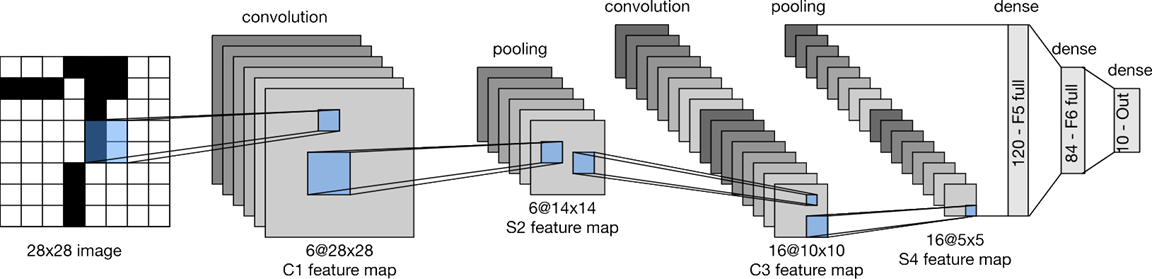<br />[image source](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html)

Essentially, the architecture of LeNet-5 can be interpreted as follows:
1. An input layer (in this case a 28x28x1 array representing the image)
2. An initial convolution layer consisting of 6 5x5 convolution kernels - this layer passes each kernel over every pixel in the image to construct 6 new "channels" (dimensions) for the 28x28 image, creating a 28x28x6 image. This convolution layer uses "padding" to preserve the dimensions of the image.
3. A 2x2 average pooling layer that reduces the 28x28x6 image into a 14x14x6 image by taking the average value of each 2x2 block of pixels and replacing the block with a single pixel.
4. Another convolution layer, this time containing 16 5x5 kernels (no padding this time, so the resulting image will be smaller) - this layer takes the 14x14x6 input and produces a 16-channel 10x10 output image
5. Another 2x2 average pooling layer - producing a 16-channel 5x5 image
6. 

In [ ]:
lenet5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), padding='same', activation='tanh', input_shape=input_shape),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='tanh'),
    tf.keras.layers.Dense(84, activation='tanh'),
    tf.keras.layers.Dense(10)
])

lenet5.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

lenet5.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=verbosity,
          validation_split=validation_split)

z = lenet5.predict(X_test) ## predict the logits, can convert these to p via: exp(z) / sum(exp(z))
## largest logit equates to largest probability, so pick element in z that is largest and that
## will be our class prediction
y_pred = np.argmax(z, axis=1)

print("LeNet-5 Model Details:")
print(lenet5.summary())
print("LeNet-5 Performance:")
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

The performance of the LeNet-5 model is a clear 4-5% better than the logistic regression. Given that the base classification accuracy was already high, this is a substantial improvement! We can also see that the confusion between digits is still there, but albeit in a smaller scale:

In [ ]:
plot_misclassified(X_test, y_test, y_pred, actual_class=9, predicted_class=4)

### Visualising the Convolutions

In [ ]:
visualise_conv = tf.keras.models.Model(
    inputs=lenet5.input,
    outputs=[layer.output for layer in lenet5.layers[:4]]
)

all_conv = visualise_conv.predict(X_test)

We now have access to ***ALL*** the data produced internall by the model. Therefore, we can examine outputs layer by layer. For example, if we wished to better understand the model, we might wahnt to look at the outputs of the first convolution layer"

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=7, figsize=(18,15))
for id in range(6):
    axs[id][0].matshow(X_test[id, :, :, 0], cmap='gray_r')
    for channel in range(6):
        axs[id][1 + channel].matshow(all_conv[0][id, :, :, channel], cmap='viridis')

The actual features will vary from run to run, but it should be clear that the convolution layers are creating "new" features that emphasise (for example) vertical and horizontal edges (regions of high contrast), contiguous blocks of similar intensity, and so on.

And we can also look at the channels of resulting from the second convolution layer and pooling (i.e., right before the flattening takes place):

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=16, figsize=(18,6))
for id in range(6):
    for channel in range(16):
        axs[id][channel].matshow(all_conv[3][id, :, :, channel], cmap='viridis')
        axs[id][channel].set_axis_off()

As the convolutions a progressively further away from the raw image, they become more abstract and less straightforward to interpret - there appears to be some discernible patterns in there, but the network is clearly not interpreting the images in a "human" way. The main point is that the inherent structure of the problem (the pixel arrangement) is being exploited to create new features that improve the network's ability to perform classification.